<div>
    <img src="https://storage.googleapis.com/kaggle-datasets-images/33180/43520/718447d8c4f7e29f129c25b44b324efa/dataset-cover.jpg"/>
</div>

In [ ]:
import numpy as np
import pandas as pd
from numpy import concatenate

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

<h1 id="dataset" style="color:#151515; background:#c4d7de; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [ ]:
path = '../input/heart-disease-uci/heart.csv'
df = pd.read_csv(path)
df = shuffle(df)
df.head()

In [ ]:
labels = df['target']
features = df.drop(columns=['target'])

#normalize
features = (features - features.mean()) / features.std()

In [ ]:
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, test_size=0.50, 
                         random_state=1, stratify=labels)
    
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = \
        train_test_split(X_train, y_train, test_size=0.50, 
                         random_state=1, stratify=y_train)

<h1 id="definition" style="color:#151515; background:#c4d7de; border:0.5px dotted;"> 
    <center>Definition
        <a class="anchor-link" href="#Definition" target="_self">¶</a>
    </center>
</h1>

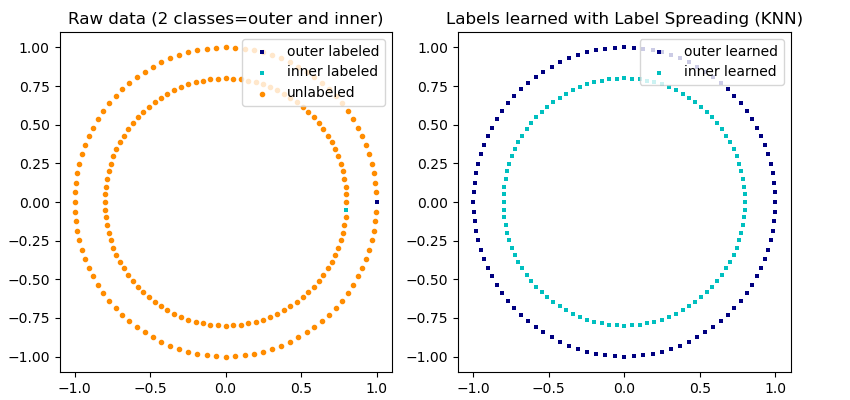

*An illustration of label-propagation: the structure of unlabeled observations is consistent with the class structure, and thus the class label can be propagated to the unlabeled observations of the training set.*


**Label Propagation** and **Label Spreading** differ in modifications to the similarity matrix that graph and the clamping effect on the label distributions. Clamping allows the algorithm to change the weight of the true ground labeled data to some degree. The Label Propagation algorithm performs hard clamping of input labels, which means alpha = 0. This clamping factor can be relaxed, to say alpha = 0.2, which means that we will always retain 80 percent of our original label distribution, but the algorithm gets to change its confidence of the distribution within 20 percent.

**Label Propagation** uses the raw similarity matrix constructed from the data with no modifications. In contrast, **Label Spreading** minimizes a loss function that has regularization properties, as such it is often more robust to noise. The algorithm iterates on a modified version of the original graph and normalizes the edge weights by computing the normalized graph Laplacian matrix. This procedure is also used in Spectral clustering.

<h1 id="propagation" style="color:#151515; background:#c4d7de; border:0.5px dotted;"> 
    <center>Label Propagation
        <a class="anchor-link" href="#propagation" target="_self">¶</a>
    </center>
</h1>

In [ ]:
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]

# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

In [ ]:
# define model
model = LabelPropagation()
# fit model on training dataset
model.fit(X_train_mixed, y_train_mixed)

In [ ]:
# get labels for entire training dataset data
train_labels = model.transduction_

# define supervised learning model
model2 = LogisticRegression()
# fit supervised learning model on entire training dataset
model2.fit(X_train_mixed, train_labels)

In [ ]:
# make predictions on hold out test set
yhat = model2.predict(X_test)

# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: {:1.3f}%'.format(score*100))

<h1 id="spreading" style="color:#151515; background:#c4d7de; border:0.5px dotted;"> 
    <center>Label Spreading
        <a class="anchor-link" href="#spreading" target="_self">¶</a>
    </center>
</h1>

In [ ]:
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]

# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

In [ ]:
# define model
model3 = LabelSpreading()
# fit model on training dataset
model3.fit(X_train_mixed, y_train_mixed)

In [ ]:
# get labels for entire training dataset data
train_labels = model3.transduction_

# define supervised learning model
model4 = LogisticRegression()
# fit supervised learning model on entire training dataset
model4.fit(X_train_mixed, train_labels)

In [ ]:
# make predictions on hold out test set
yhat = model4.predict(X_test)

# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: {:1.3f}%'.format(score*100))

<h1 id="blending" style="color:#151515; background:#c4d7de; border:0.5px dotted;"> 
    <center>Blending
        <a class="anchor-link" href="#blending" target="_self">¶</a>
    </center>
</h1>

In [ ]:
def stack_preds(X):
    s_X = np.vstack((model2.predict(X), model4.predict(X)))
    return np.swapaxes(s_X, 0, 1)

In [ ]:
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('cart', DecisionTreeClassifier()))
    models.append(('svm', SVC(probability=True)))
    models.append(('bayes', GaussianNB()))
    return models

In [ ]:
models = get_models()
for name, model in models:
    model.fit(stack_preds(X_train), y_train)
    yhat = model.predict(stack_preds(X_test))
    score = accuracy_score(y_test.values, yhat)
    print('Model:{:6s} -- Accuracy: {:1.3f}%'
              .format(name, score*100))

In [ ]:
ensemble = VotingClassifier(estimators=models, voting='hard')

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Voting Ensemble - Mean Accuracy: {:1.3f}% - Standard Deviation: {:1.3f}'
          .format((n_scores).mean() * 100, (n_scores).std()))